In [246]:
!pip install pmdarima

In [247]:
# import các thư viện cần thiết
import numpy as np
import pandas as pd
import math
# vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns
# kiểm định và xây dựng mô hình
from statsmodels.api import tsa
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler # chuyển đổi dữ liệu
from scipy import stats
import statsmodels.api as sm

2. Tải, hợp nhất dữ liệu

In [249]:
d1=pd.read_csv("Desktop/CVT Historical Data.csv", parse_dates= True)
d2=pd.read_csv("Desktop/HBC Historical Data.csv", parse_dates= True)
d3=pd.read_csv("Desktop/HT1 Historical Data.csv", parse_dates= True)
d4=pd.read_csv("Desktop/ACC Historical Data.csv", parse_dates= True)
d5=pd.read_csv("Desktop/VCG Historical Data.csv", parse_dates= True)

In [250]:
d1.columns=["Date", "Price_CVT","Open_CVT","High_CVT","Low_CVT","Vol_CVT","Change_CVT"]
d1.Date = list(reversed(d1.Date))
d1.Price_CVT = list(reversed(d1.Price_CVT))
d2.columns=["Date", "Price_HBC","Open_HBC","High_HBC","Low_HBC","Vol_HBC","Change_HBC"]
d2.Date = list(reversed(d2.Date))
d2.Price_HBC = list(reversed(d2.Price_HBC))
d3.columns=["Date", "Price_HT1","Open_HT1","High_HT1","Low_HT1","Vol_HT1","Change_HT1"]
d3.Date = list(reversed(d3.Date))
d3.Price_HT1 = list(reversed(d3.Price_HT1))
d4.columns=["Date", "Price_ACC","Open_ACC","High_ACC","Low_ACC","Vol_ACC","Change_ACC"]
d4.Date = list(reversed(d4.Date))
d4.Price_ACC = list(reversed(d4.Price_ACC))
d5.columns=["Date", "Price_VCG","Open_VCG","High_VCG","Low_VCG","Vol_VCG","Change_VCG"]
d5.Date = list(reversed(d5.Date))
d5.Price_VCG = list(reversed(d5.Price_VCG))


In [251]:
def Create_date(start, end):
# Tạo chuỗi ngày
  date_range = pd.date_range(start=start, end=end, freq='D')
# Chuyển đổi chuỗi ngày sang chuỗi
  date_strings = date_range.strftime('%m/%d/%y').tolist()
# Chỉnh lại định dạng về dd/mm/yyyy
  for i in range(len(date_strings)):
    x1 = '2'
    x2 = '0'
    date_strings[i]=f"{date_strings[i][0:6]}{x1}{x2}{date_strings[i][6:]}"
  # đưa về DataFrame
  df=pd.DataFrame(date_strings, columns=["Date"])
  return df
df=Create_date("2019-01-02","2024-01-26")
df

,Date
0,01/02/2019
1,01/03/2019
2,01/04/2019
3,01/05/2019
4,01/06/2019
...,...
1846,01/22/2024
1847,01/23/2024
1848,01/24/2024
1849,01/25/2024


In [252]:
# ghép các bảng
data=df.merge(d1[["Date","Price_CVT"]], how="outer", on = "Date")
data=data.merge(d2[["Date","Price_HBC"]], how="outer", on = "Date")
data=data.merge(d3[["Date","Price_HT1"]], how="outer", on = "Date")
data=data.merge(d4[["Date","Price_ACC"]], how="outer", on = "Date")
data=data.merge(d5[["Date","Price_VCG"]], how="outer", on = "Date")
data


,Date,Price_CVT,Price_HBC,Price_HT1,Price_ACC,Price_VCG
0,01/02/2019,"18,850.0","13,704.3","13,600.0","13,478.9","15,182.1"
1,01/03/2019,"17,750.0","12,766.2","12,850.0","13,856.8","15,050.1"
2,01/04/2019,"18,200.0","12,643.8","13,250.0","12,912.0","14,456.0"
3,01/05/2019,NaN,NaN,NaN,NaN,NaN
4,01/06/2019,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1846,01/22/2024,"31,000.0","9,200.0","12,650.0","11,850.0","25,000.0"
1847,01/23/2024,NaN,"9,150.0","12,750.0","11,800.0","25,400.0"
1848,01/24/2024,"31,150.0","9,150.0","12,700.0","11,700.0","25,250.0"
1849,01/25/2024,"29,800.0","9,010.0","12,600.0","11,700.0","25,250.0"


In [253]:
# hàm chuyển về kiểu numeric
def To_numeric(i):
  i=i.str.replace(",","")
  i=i.astype("f")
  return i
data.Price_CVT=To_numeric(data.Price_CVT)
data.Price_HBC=To_numeric(data.Price_HBC)
data.Price_HT1=To_numeric(data.Price_HT1)
data.Price_ACC=To_numeric(data.Price_ACC)
data.Price_VCG=To_numeric(data.Price_VCG)

In [254]:
# Set cột date là index
data.Date=pd.to_datetime(data.Date)
data.set_index('Date', inplace=True)


In [255]:
# Chuyễn dữ liệu sang dạng tuần
data.Price_CVT=data["Price_CVT"].resample("W").apply(np.mean).ffill()
data.Price_HBC=data["Price_HBC"].resample("W").apply(np.mean).ffill()
data.Price_HT1=data["Price_HT1"].resample("W").apply(np.mean).ffill()
data.Price_VCG=data["Price_VCG"].resample("W").apply(np.mean).ffill()
data.Price_ACC=data["Price_ACC"].resample("W").apply(np.mean).ffill()

data.dropna(inplace = True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_1672\2126899403.py:2: FutureWarning: The provided callable <function mean at 0x00000236603E85E0> is currently using DatetimeIndexResampler.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data.Price_CVT=data["Price_CVT"].resample("W").apply(np.mean).ffill()
C:\Users\DELL\AppData\Local\Temp\ipykernel_1672\2126899403.py:3: FutureWarning: The provided callable <function mean at 0x00000236603E85E0> is currently using DatetimeIndexResampler.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data.Price_HBC=data["Price_HBC"].resample("W").apply(np.mean).ffill()
C:\Users\DELL\AppData\Local\Temp\ipykernel_1672\2126899403.py:4: FutureWarning: The provided callable <function mean at 0x00000236603E85E0> is currently using DatetimeIndexResampler.mean. In a future version of pan

3. Khám phá dữ liệu

In [256]:
data

,Price_CVT,Price_HBC,Price_HT1,Price_ACC,Price_VCG
Date,,,,,
2019-01-06,18266.666016,13038.100586,13233.333008,13415.899414,14896.066406
2019-01-13,18610.000000,13068.020508,13680.000000,13163.919922,15168.900391
2019-01-20,18840.000000,13492.220703,14010.000000,13667.820312,15076.458984
2019-01-27,20370.000000,13312.720703,15000.000000,13368.675781,15340.500000
2019-02-03,20390.000000,13100.660156,15380.000000,13334.020508,16343.861328
...,...,...,...,...,...
2023-12-24,32083.333984,7640.000000,11990.000000,12290.000000,23900.000000
2023-12-31,30900.000000,7924.000000,12060.000000,12370.000000,24550.000000
2024-01-07,30816.666016,7922.500000,12312.500000,12337.500000,24762.500000


In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2019-01-06 to 2024-01-21
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price_CVT  264 non-null    float32
 1   Price_HBC  264 non-null    float32
 2   Price_HT1  264 non-null    float32
 3   Price_ACC  264 non-null    float32
 4   Price_VCG  264 non-null    float32
dtypes: float32(5)
memory usage: 7.2 KB


In [258]:
data.describe()

,Price_CVT,Price_HBC,Price_HT1,Price_ACC,Price_VCG
count,264.000000,264.000000,264.000000,264.000000,264.000000
mean,32962.882812,13060.211914,15504.176758,11817.578125,23636.523438
std,10683.874023,5259.863770,3095.168213,3923.613037,7172.985352
min,15150.000000,5541.700195,8056.000000,4568.739746,11590.919922
25%,20845.000000,9131.939941,13833.699707,7730.024902,18071.379883
50%,37620.000000,12020.090332,15140.000000,12932.560059,20377.269531
75%,41508.758789,15201.610352,16289.055176,13692.534424,31365.674805
max,49860.000000,31203.250000,24488.140625,23559.500000,43708.226562


In [259]:
import statsmodels
jb1=statsmodels.stats.stattools.jarque_bera(data.Price_CVT)
jb2=statsmodels.stats.stattools.jarque_bera(data.Price_HBC)
jb3=statsmodels.stats.stattools.jarque_bera(data.Price_HT1)
jb4=statsmodels.stats.stattools.jarque_bera(data.Price_ACC)
jb5=statsmodels.stats.stattools.jarque_bera(data.Price_VCG)
print(jb1)
print(jb2)
print(jb3)
print(jb4)
print(jb5)

(28.230244908189462, 7.4110579089974e-07, -0.3087572316851646, 1.521804550043212)
(73.76988769778431, 9.573537022476246e-17, 1.201365322043188, 3.9660428971011434)
(47.23967924600855, 5.521206470645578e-11, 0.8860328849270029, 4.0743831729897)
(0.2793888220927703, 0.8696239422687523, 0.0258827171977769, 2.849270694195007)
(27.060793130180006, 1.3299136201571977e-06, 0.6481406445736435, 2.1169785267898154)


In [260]:
def Id_max(df, y):
    idx = np.where(df[y]==max(df[y]))
    date = df.iloc[idx]
    print(f"Giá trị cổ phiếu CVT đạt max là {max(df[y])} vào ngày {date.index[0]}")
Id_max(data, "Price_CVT")
Id_max(data, "Price_HBC")
Id_max(data, "Price_HT1")
Id_max(data, "Price_ACC")
Id_max(data, "Price_VCG")

Giá trị cổ phiếu CVT đạt max là 49860.0 vào ngày 2021-12-12 00:00:00
Giá trị cổ phiếu CVT đạt max là 31203.25 vào ngày 2022-01-09 00:00:00
Giá trị cổ phiếu CVT đạt max là 24488.140625 vào ngày 2021-11-21 00:00:00
Giá trị cổ phiếu CVT đạt max là 23559.5 vào ngày 2022-03-13 00:00:00
Giá trị cổ phiếu CVT đạt max là 43708.2265625 vào ngày 2022-01-09 00:00:00


In [261]:
def Id_min(df, y):
    idx = np.where(df[y]==min(df[y]))
    date = df.iloc[idx]
    print(f"Giá trị cổ phiếu CVT đạt min là {max(df[y])} vào ngày {date.index[0]}")
Id_min(data, "Price_CVT")
Id_min(data, "Price_HBC")
Id_min(data, "Price_HT1")
Id_min(data, "Price_ACC")
Id_min(data, "Price_VCG")

Giá trị cổ phiếu CVT đạt min là 49860.0 vào ngày 2020-03-29 00:00:00
Giá trị cổ phiếu CVT đạt min là 31203.25 vào ngày 2020-04-05 00:00:00
Giá trị cổ phiếu CVT đạt min là 24488.140625 vào ngày 2022-11-20 00:00:00
Giá trị cổ phiếu CVT đạt min là 23559.5 vào ngày 2020-08-02 00:00:00
Giá trị cổ phiếu CVT đạt min là 43708.2265625 vào ngày 2022-11-20 00:00:00


Text(0.5, 1.0, 'VCG')

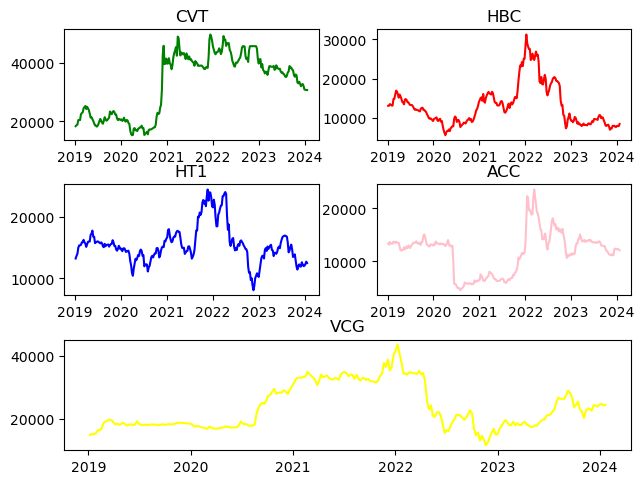

In [262]:
# Show dữ liệu theo tuần
fig = plt.figure()
axes1 = plt.subplot2grid((3,2), (0,0))
axes2 = plt.subplot2grid((3,2), (0,1))
axes3 = plt.subplot2grid((3,2), (1,0))
axes4 = plt.subplot2grid((3,2), (1,1))
axes5 = plt.subplot2grid((3,2), (2,0), colspan = 2)
fig.tight_layout()
axes1.plot(data['Price_CVT'], color="green")
axes1.set_title("CVT")
axes2.plot(data['Price_HBC'], color="red")
axes2.set_title("HBC")
axes3.plot(data['Price_HT1'], color="blue")
axes3.set_title("HT1")
axes4.plot(data['Price_ACC'], color="pink")
axes4.set_title("ACC")
axes5.plot(data['Price_VCG'], color="yellow")
axes5.set_title("VCG")


C:\Users\DELL\AppData\Local\Temp\ipykernel_1672\3953790915.py:3: FutureWarning: The provided callable <function mean at 0x00000236603E85E0> is currently using DatetimeIndexResampler.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  cvg_monthly_priceCVT=data.Price_CVT.resample("M").apply(np.mean)
C:\Users\DELL\AppData\Local\Temp\ipykernel_1672\3953790915.py:4: FutureWarning: The provided callable <function mean at 0x00000236603E85E0> is currently using DatetimeIndexResampler.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  cvg_monthly_priceHBC=data.Price_HBC.resample("M").apply(np.mean)
C:\Users\DELL\AppData\Local\Temp\ipykernel_1672\3953790915.py:5: FutureWarning: The provided callable <function mean at 0x00000236603E85E0> is currently using DatetimeIndexResampler.mean. In a future version of pandas, the p

Text(0.5, 1.0, 'VCG')

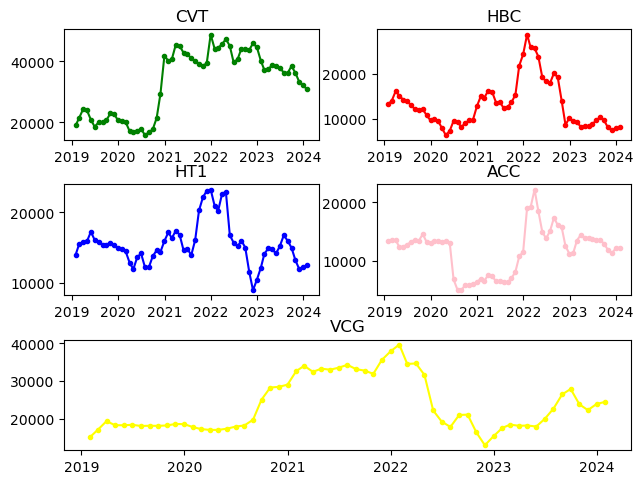

In [263]:
# Dữ liệu giá hàng tháng

cvg_monthly_priceCVT=data.Price_CVT.resample("M").apply(np.mean)
cvg_monthly_priceHBC=data.Price_HBC.resample("M").apply(np.mean)
cvg_monthly_priceHT1=data.Price_HT1.resample("M").apply(np.mean)
cvg_monthly_priceACC=data.Price_ACC.resample("M").apply(np.mean)
cvg_monthly_priceVCG=data.Price_VCG.resample("M").apply(np.mean)
fig = plt.figure()
axes1 = plt.subplot2grid((3,2), (0,0))
axes2 = plt.subplot2grid((3,2), (0,1))
axes3 = plt.subplot2grid((3,2), (1,0))
axes4 = plt.subplot2grid((3,2), (1,1))
axes5 = plt.subplot2grid((3,2), (2,0), colspan = 2)
fig.tight_layout()
axes1.plot(cvg_monthly_priceCVT,"-o", markersize=3, color="green", )
axes1.set_title("CVT")
axes2.plot(cvg_monthly_priceHBC, "-o", markersize=3,color="red")
axes2.set_title("HBC")
axes3.plot(cvg_monthly_priceHT1, "-o", markersize=3,color="blue")
axes3.set_title("HT1")
axes4.plot(cvg_monthly_priceACC,"-o", markersize=3, color="pink")
axes4.set_title("ACC")
axes5.plot(cvg_monthly_priceVCG,"-o", markersize=3, color="yellow")
axes5.set_title("VCG")



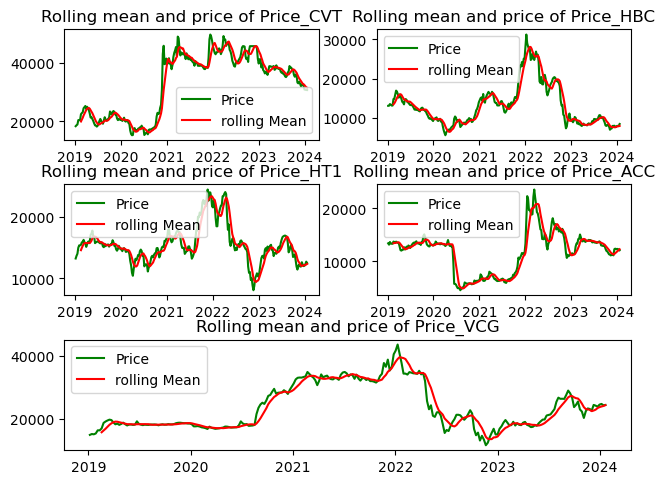

In [266]:
def Rolling_mean(data,x, ax):
    roll = data.rolling(window=7, center = False).mean()
    ax.plot(data, color="green", label = 'Price')
    ax.plot(roll, color = "red", label = "rolling Mean")
    ax.set_title(f"Rolling mean and price of {x}")
    ax.legend()
    
fig = plt.figure()
axes1 = plt.subplot2grid((3,2), (0,0))
axes2 = plt.subplot2grid((3,2), (0,1))
axes3 = plt.subplot2grid((3,2), (1,0))
axes4 = plt.subplot2grid((3,2), (1,1))
axes5 = plt.subplot2grid((3,2), (2,0), colspan = 2)
fig.tight_layout()
Rolling_mean(data.Price_CVT,"Price_CVT", axes1)
Rolling_mean(data.Price_HBC,"Price_HBC", axes2)
Rolling_mean(data.Price_HT1,"Price_HT1", axes3)
Rolling_mean(data.Price_ACC,"Price_ACC", axes4)
Rolling_mean(data.Price_VCG,"Price_VCG", axes5)





<Figure size 800x600 with 0 Axes>

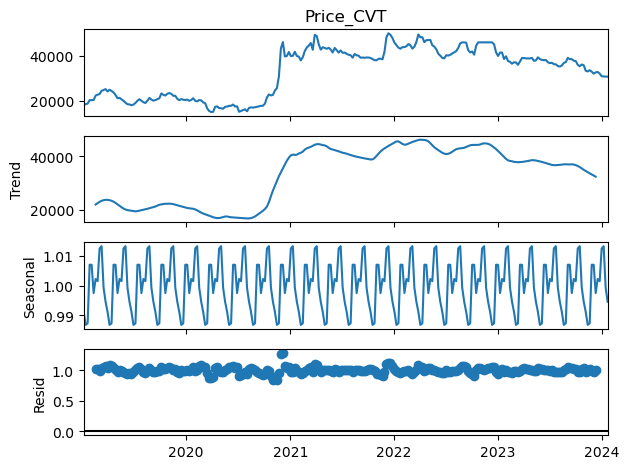

<Figure size 800x600 with 0 Axes>

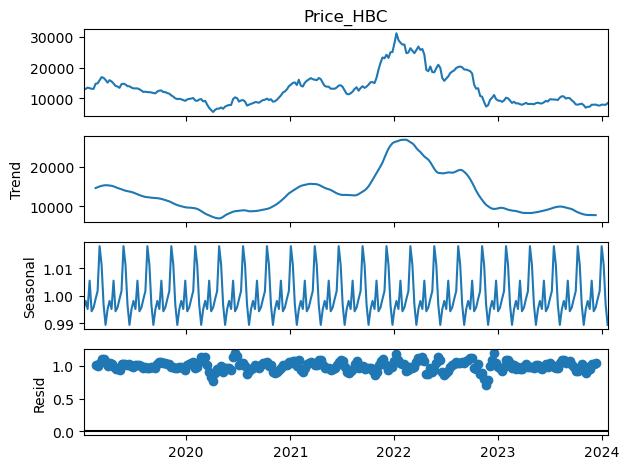

<Figure size 800x600 with 0 Axes>

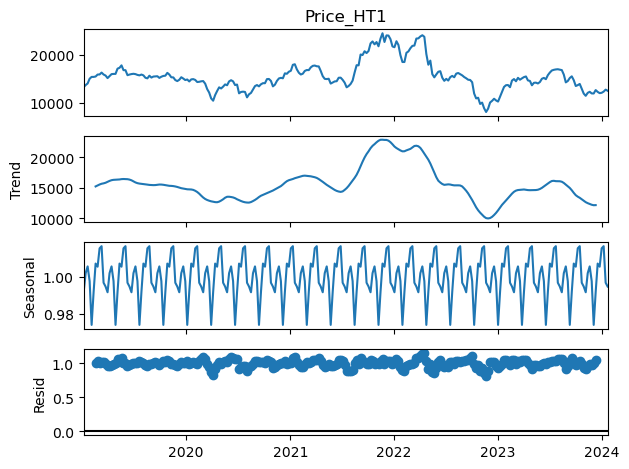

<Figure size 800x600 with 0 Axes>

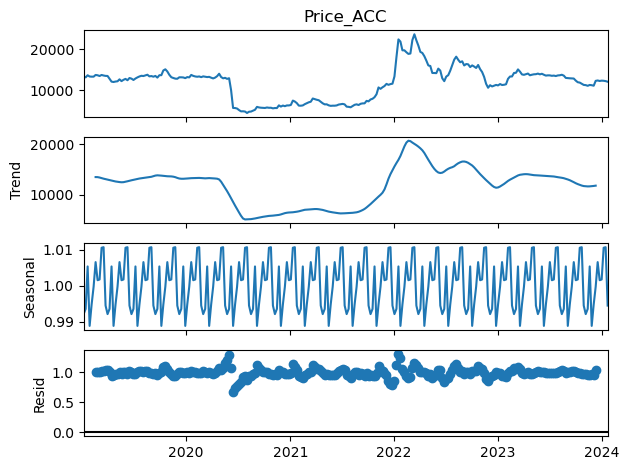

<Figure size 800x600 with 0 Axes>

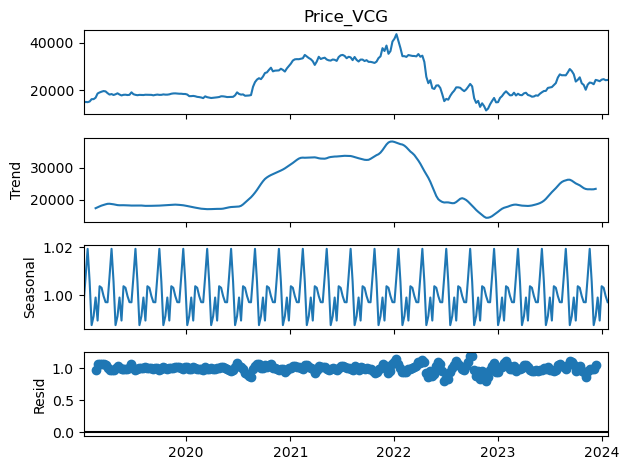

In [267]:
# Không đứng yên thì cần loại bỏ xu thế
# Phân tách chuỗi thời gian thành xu hướng và tính mùa vụ
def Seasonal(x):
  Seasonal_decompose=seasonal_decompose(x, model = 'multiplicative', period=12)
  plt.figure(figsize=(8,6))
  Seasonal_decompose.plot()
Seasonal(data["Price_CVT"])
Seasonal(data["Price_HBC"])
Seasonal(data["Price_HT1"])
Seasonal(data["Price_ACC"])
Seasonal(data["Price_VCG"])




5. Kiểm định tính dừng

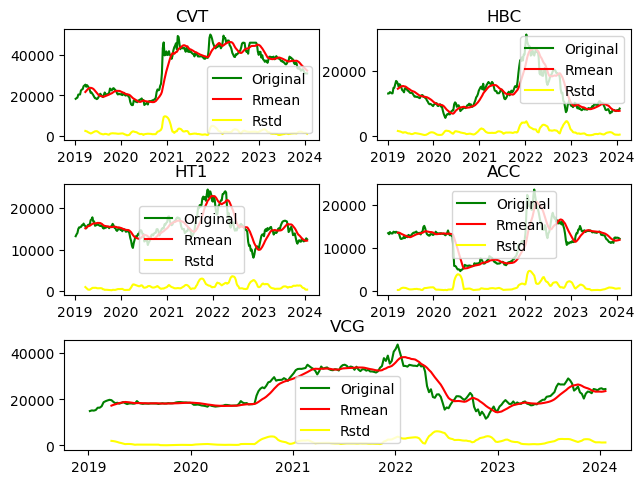

In [268]:
def Rolling_test(data,y,x):
# C1: Sử dụng Rolling Statistic
  rolling_mean=data.rolling(12).mean() # xác định rolling_mean
  rolling_std=data.rolling(12).std() # Xác định roliing_std
  # plot original data
  x.plot(data, color="g", label="Original")
  # plot rolling mean
  x.plot(rolling_mean, color='r', label="Rmean")
  # plot rolling std
  x.plot(rolling_std, color='yellow', label="Rstd")
  x.legend(loc="best")
  x.set_title(y)
fig = plt.figure()
axes1 = plt.subplot2grid((3,2), (0,0))
axes2 = plt.subplot2grid((3,2), (0,1))
axes3 = plt.subplot2grid((3,2), (1,0))
axes4 = plt.subplot2grid((3,2), (1,1))
axes5 = plt.subplot2grid((3,2), (2,0), colspan = 2)
fig.tight_layout()
Rolling_test(data.Price_CVT,"CVT", axes1)
Rolling_test(data.Price_HBC,"HBC", axes2)
Rolling_test(data.Price_HT1,"HT1", axes3)
Rolling_test(data.Price_ACC,"ACC", axes4)
Rolling_test(data.Price_VCG,"VCG", axes5)


In [269]:
# C2: Kiểm định Dickey Fuller
def adf_test(data,x):
  print(f"ADF test for {x}")
  indices=["Test Stastitic","p_value","# Of Lags Used","# Observation Used"]
  adf_result=adfuller(data)
  results=pd.Series(adf_result[0:4],index=indices)
  for key,value in adf_result[4].items():
    results[f'Critial Value({key})']=value
  print(results)
  print("\n")
# CVT
adf_test(data.Price_CVT,"Price_CVT")
# HBC
adf_test(data.Price_HBC,"Price_HBC")
# ACC
adf_test(data.Price_ACC,"Price_ACC")
# HT1
adf_test(data.Price_HT1,"Price_HT1")
# VCG
adf_test(data.Price_VCG,"Price_VCG")




ADF test for Price_CVT
Test Stastitic         -1.609498
p_value                 0.478821
# Of Lags Used          3.000000
# Observation Used    260.000000
Critial Value(1%)      -3.455754
Critial Value(5%)      -2.872721
Critial Value(10%)     -2.572728
dtype: float64


ADF test for Price_HBC
Test Stastitic         -1.763564
p_value                 0.398695
# Of Lags Used          3.000000
# Observation Used    260.000000
Critial Value(1%)      -3.455754
Critial Value(5%)      -2.872721
Critial Value(10%)     -2.572728
dtype: float64


ADF test for Price_ACC
Test Stastitic         -2.048691
p_value                 0.265640
# Of Lags Used          2.000000
# Observation Used    261.000000
Critial Value(1%)      -3.455656
Critial Value(5%)      -2.872678
Critial Value(10%)     -2.572705
dtype: float64


ADF test for Price_HT1
Test Stastitic         -2.367828
p_value                 0.151023
# Of Lags Used          1.000000
# Observation Used    262.000000
Critial Value(1%)      -3.455558

6. Kiểm định dừng của sai phân bậc 1

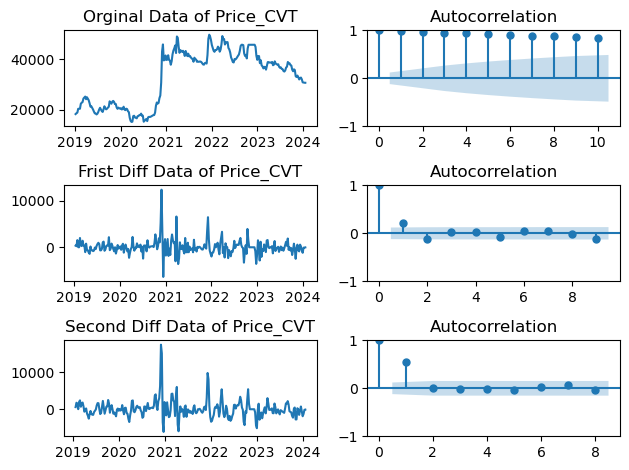

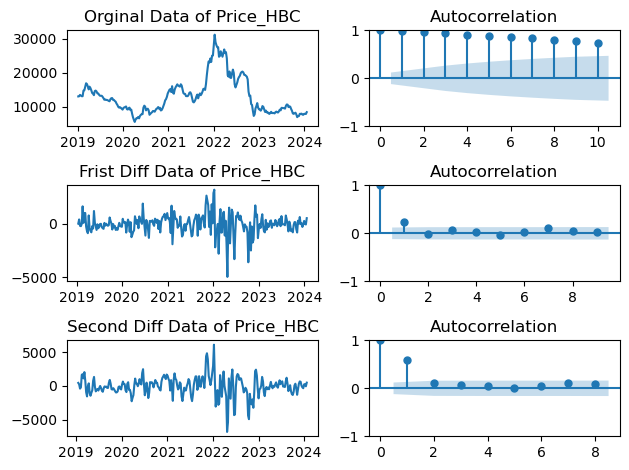

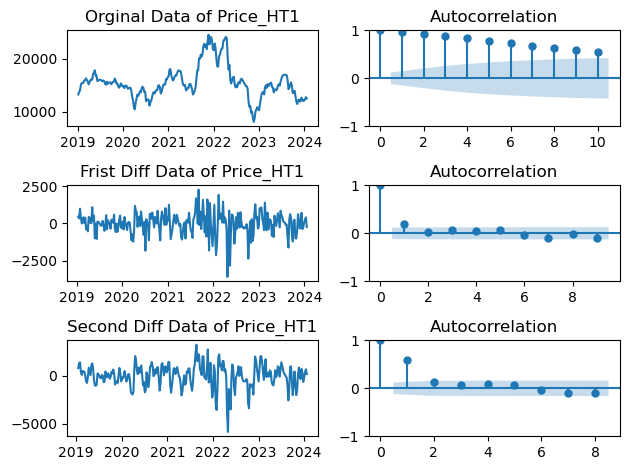

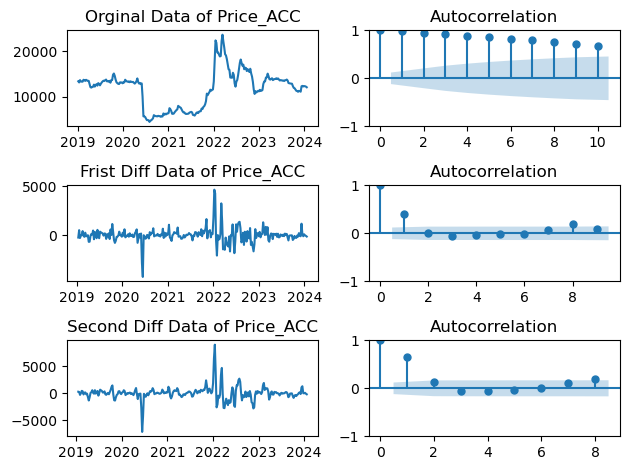

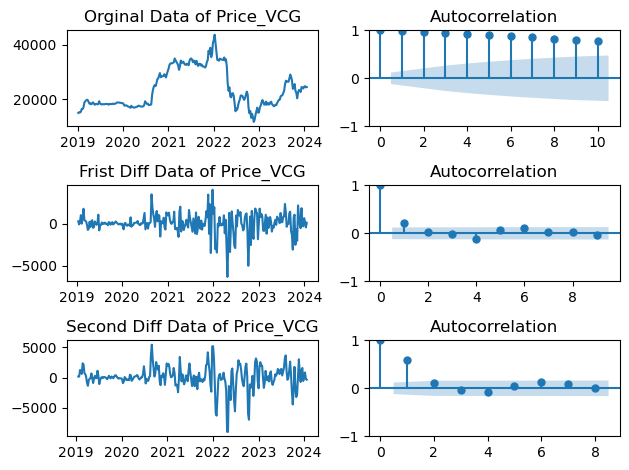

In [270]:
def Auto_correclation(data,x):
  fig, ax = plt.subplots(3,2, sharex=False)
  # vẽ đồ thị cho dữ liệu ban đầu
  ax[0,0].plot(data)
  ax[0,0].set_title(f"Orginal Data of {x}")
  plot_acf(data, lags=10, ax = ax[0,1])
  # vẽ đồ thị cho sai phân bậc 1
  data_diff=data.diff(1).dropna()
  ax[1,0].plot(data_diff)
  ax[1,0].set_title(f"Frist Diff Data of {x}")
  plot_acf(data_diff, lags=9, ax = ax[1,1])
  # Vẽ đồ thị cho sai phân bậc 2
  data_diff_diff=data.diff(2).dropna()
  ax[2,0].plot(data_diff_diff)
  ax[2,0].set_title(f"Second Diff Data of {x}")
  plot_acf(data_diff_diff, lags=8, ax = ax[2,1])

  plt.tight_layout()
  plt.show()
Auto_correclation(data.Price_CVT,"Price_CVT")
Auto_correclation(data.Price_HBC,"Price_HBC")
Auto_correclation(data.Price_HT1,"Price_HT1")
Auto_correclation(data.Price_ACC,"Price_ACC")
Auto_correclation(data.Price_VCG,"Price_VCG")


In [271]:
# Check lại xem dữ liệu sau sai phân đã dừng hay chưa
adf_test(data.Price_CVT.diff(1).dropna(), "Price_CVT")
adf_test(data.Price_HBC.diff(1).dropna(), "Price_HBC")
adf_test(data.Price_HT1.diff(1).dropna(), "Price_HT1")
adf_test(data.Price_ACC.diff(1).dropna(), "Price_ACC")
adf_test(data.Price_VCG.diff(1).dropna(), "Price_VCG")

ADF test for Price_CVT
Test Stastitic       -1.185416e+01
p_value               7.092722e-22
# Of Lags Used        1.000000e+00
# Observation Used    2.610000e+02
Critial Value(1%)    -3.455656e+00
Critial Value(5%)    -2.872678e+00
Critial Value(10%)   -2.572705e+00
dtype: float64


ADF test for Price_HBC
Test Stastitic       -7.967793e+00
p_value               2.834131e-12
# Of Lags Used        2.000000e+00
# Observation Used    2.600000e+02
Critial Value(1%)    -3.455754e+00
Critial Value(5%)    -2.872721e+00
Critial Value(10%)   -2.572728e+00
dtype: float64


ADF test for Price_HT1
Test Stastitic       -1.315183e+01
p_value               1.361991e-24
# Of Lags Used        0.000000e+00
# Observation Used    2.620000e+02
Critial Value(1%)    -3.455558e+00
Critial Value(5%)    -2.872636e+00
Critial Value(10%)   -2.572683e+00
dtype: float64


ADF test for Price_ACC
Test Stastitic       -1.049798e+01
p_value               1.102756e-18
# Of Lags Used        1.000000e+00
# Observation Use

Text(0.5, 1.0, 'First Diff VCG')

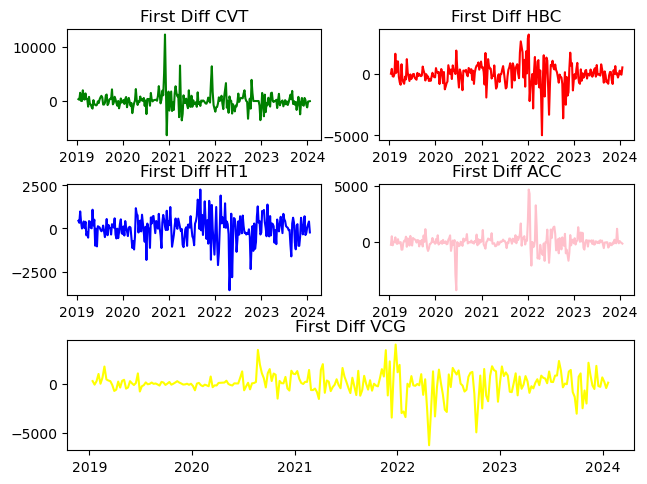

In [272]:
fig = plt.figure()
axes1 = plt.subplot2grid((3,2), (0,0))
axes2 = plt.subplot2grid((3,2), (0,1))
axes3 = plt.subplot2grid((3,2), (1,0))
axes4 = plt.subplot2grid((3,2), (1,1))
axes5 = plt.subplot2grid((3,2), (2,0), colspan = 2)
fig.tight_layout()
axes1.plot(data.Price_CVT.diff(1).dropna(), color = "green")
axes1.set_title("First Diff CVT")
axes2.plot(data.Price_HBC.diff(1).dropna(), color = "red")
axes2.set_title("First Diff HBC")
axes3.plot(data.Price_HT1.diff(1).dropna(), color = "blue")
axes3.set_title("First Diff HT1")
axes4.plot(data.Price_ACC.diff(1).dropna(), color = "pink")
axes4.set_title("First Diff ACC")
axes5.plot(data.Price_VCG.diff(1).dropna(), color = "yellow")
axes5.set_title("First Diff VCG")

In [273]:
data

,Price_CVT,Price_HBC,Price_HT1,Price_ACC,Price_VCG
Date,,,,,
2019-01-06,18266.666016,13038.100586,13233.333008,13415.899414,14896.066406
2019-01-13,18610.000000,13068.020508,13680.000000,13163.919922,15168.900391
2019-01-20,18840.000000,13492.220703,14010.000000,13667.820312,15076.458984
2019-01-27,20370.000000,13312.720703,15000.000000,13368.675781,15340.500000
2019-02-03,20390.000000,13100.660156,15380.000000,13334.020508,16343.861328
...,...,...,...,...,...
2023-12-24,32083.333984,7640.000000,11990.000000,12290.000000,23900.000000
2023-12-31,30900.000000,7924.000000,12060.000000,12370.000000,24550.000000
2024-01-07,30816.666016,7922.500000,12312.500000,12337.500000,24762.500000


7. Chia tập dữ liệu train và test_set

In [274]:
r = int(len(data.Price_VCG)*0.9)
train_set = pd.DataFrame((data.iloc[:r]).rename(columns={"Price_VCG":"Y_train_VCG","Price_CVT":"Y_train_CVT","Price_HT1":"Y_train_HT1","Price_ACC":"Y_train_ACC","Price_HBC":"Y_train_HBC" }))
test_set = pd.DataFrame((data.iloc[r:]).rename(columns={"Price_VCG":"Y_test_VCG", "Price_CVT":"Y_test_CVT","Price_HT1":"Y_test_HT1","Price_ACC":"Y_test_ACC","Price_HBC":"Y_test_HBC"}))

In [275]:
print(train_set.shape)
print(test_set.shape)

(237, 5)
(27, 5)


In [276]:
train_set

,Y_train_CVT,Y_train_HBC,Y_train_HT1,Y_train_ACC,Y_train_VCG
Date,,,,,
2019-01-06,18266.666016,13038.100586,13233.333008,13415.899414,14896.066406
2019-01-13,18610.000000,13068.020508,13680.000000,13163.919922,15168.900391
2019-01-20,18840.000000,13492.220703,14010.000000,13667.820312,15076.458984
2019-01-27,20370.000000,13312.720703,15000.000000,13368.675781,15340.500000
2019-02-03,20390.000000,13100.660156,15380.000000,13334.020508,16343.861328
...,...,...,...,...,...
2023-06-18,38087.500000,9164.000000,14900.000000,13590.000000,19813.640625
2023-06-25,37100.000000,8954.000000,15750.000000,13650.000000,21070.000000
2023-07-02,36687.500000,9688.000000,16290.000000,13640.000000,21260.000000


In [277]:
test_set

,Y_test_CVT,Y_test_HBC,Y_test_HT1,Y_test_ACC,Y_test_VCG
Date,,,,,
2023-07-23,36162.500000,9572.0,16940.0,13480.0,23100.0
2023-07-30,35425.000000,9446.0,16980.0,13630.0,25430.0
2023-08-06,35187.500000,10238.0,16880.0,13670.0,26770.0
2023-08-13,35625.000000,10670.0,16800.0,13790.0,26400.0
2023-08-20,36800.000000,10612.0,15860.0,13580.0,26420.0
2023-08-27,37125.000000,9910.0,14240.0,13030.0,26370.0
2023-09-03,39000.000000,10125.0,14525.0,12975.0,27612.5
2023-09-10,38450.000000,10025.0,15150.0,12937.5,29025.0
2023-09-17,38450.000000,9354.0,15500.0,12910.0,28170.0


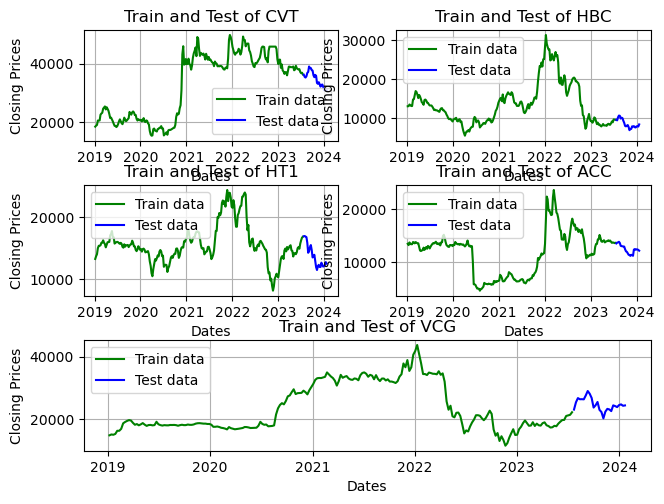

In [278]:
# trực quan hóa dữ liệu 
fig = plt.figure()
axes1 = plt.subplot2grid((3,2), (0,0))
axes2 = plt.subplot2grid((3,2), (0,1))
axes3 = plt.subplot2grid((3,2), (1,0))
axes4 = plt.subplot2grid((3,2), (1,1))
axes5 = plt.subplot2grid((3,2), (2,0), colspan = 2)
fig.tight_layout()
def Show1(data1, data2, x, y):
  y.grid(True)
  y.set_xlabel('Dates')
  y.set_ylabel('Closing Prices')
  y.plot(data1, 'green', label='Train data')
  y.plot(data2, 'blue', label='Test data')
  y.legend()
  y.set_title(f"Train and Test of {x}")
Show1(train_set.Y_train_CVT, test_set.Y_test_CVT, "CVT", axes1)
Show1(train_set.Y_train_HBC, test_set.Y_test_HBC, "HBC", axes2)
Show1(train_set.Y_train_HT1, test_set.Y_test_HT1, "HT1", axes3)
Show1(train_set.Y_train_ACC, test_set.Y_test_ACC, "ACC", axes4)
Show1(train_set.Y_train_VCG, test_set.Y_test_VCG, "VCG", axes5)



8. Ước lượng tham số mô hình bằng đồ thị PACF và ACF

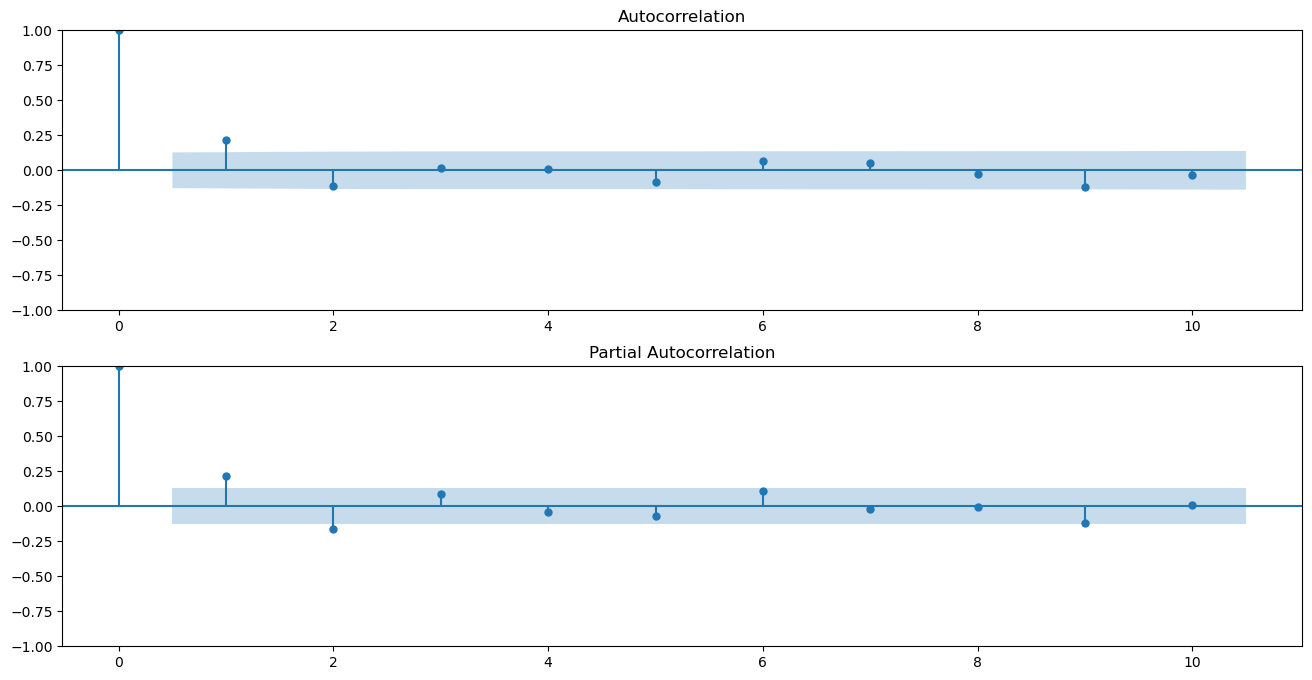

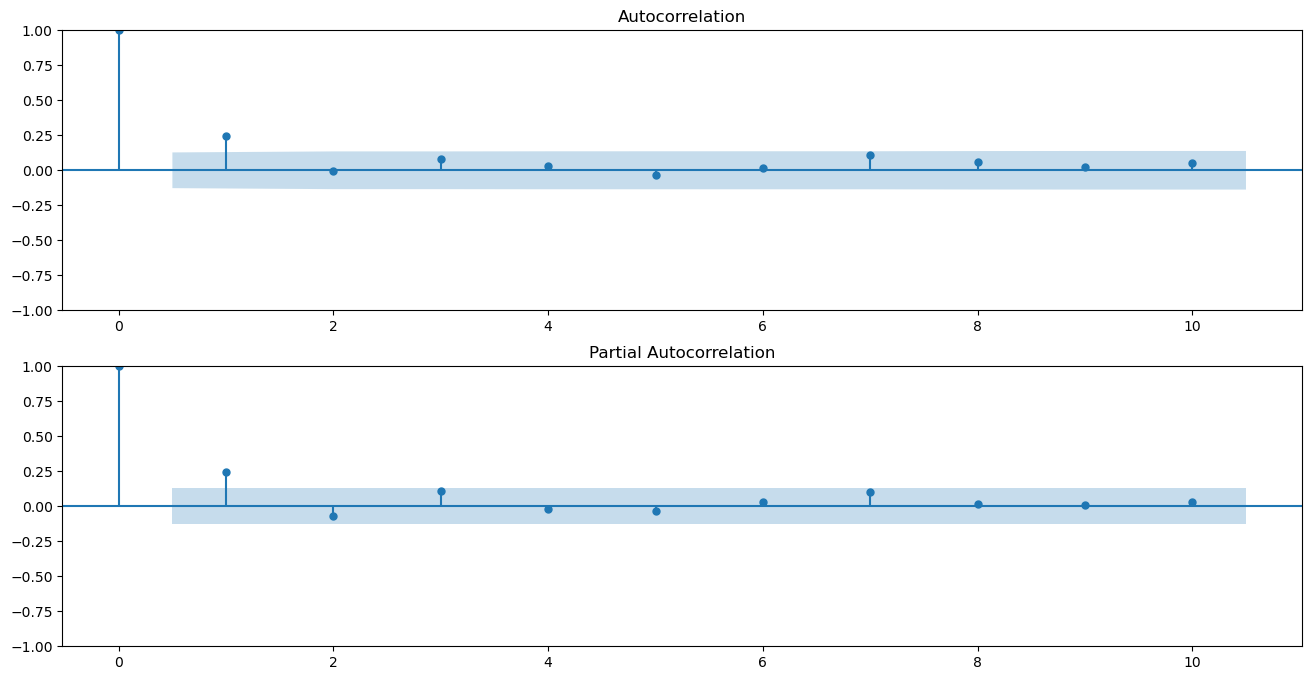

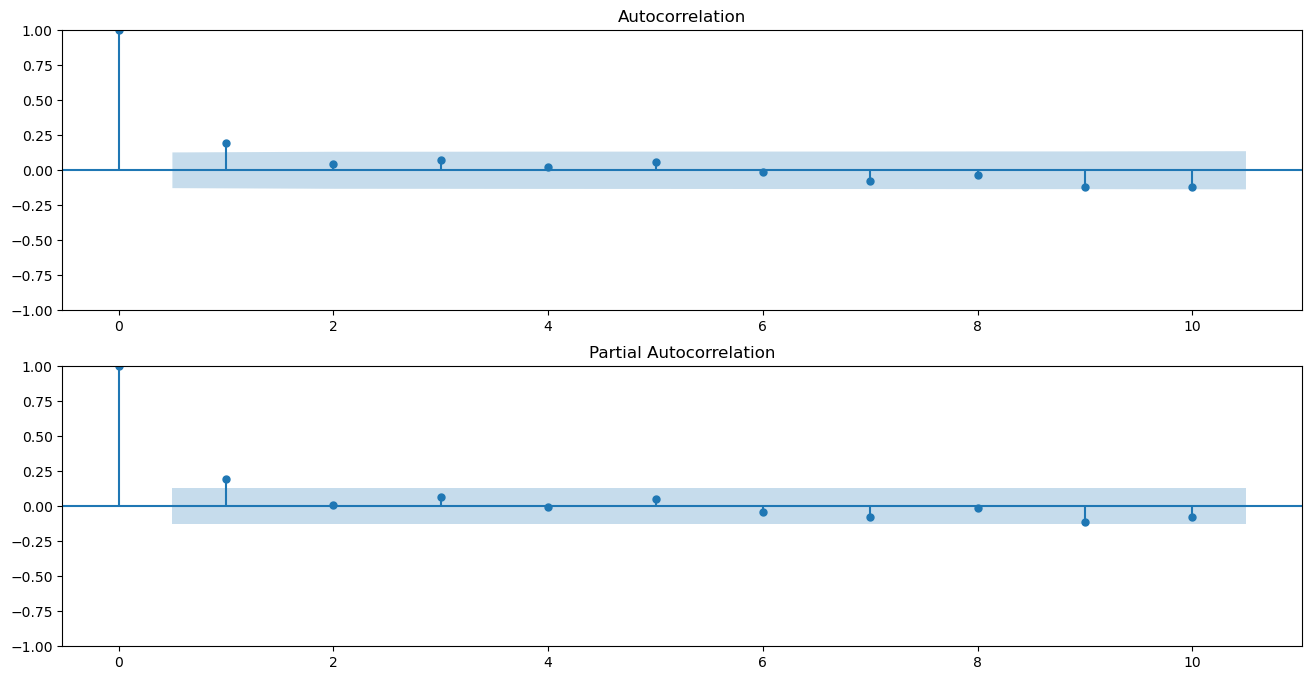

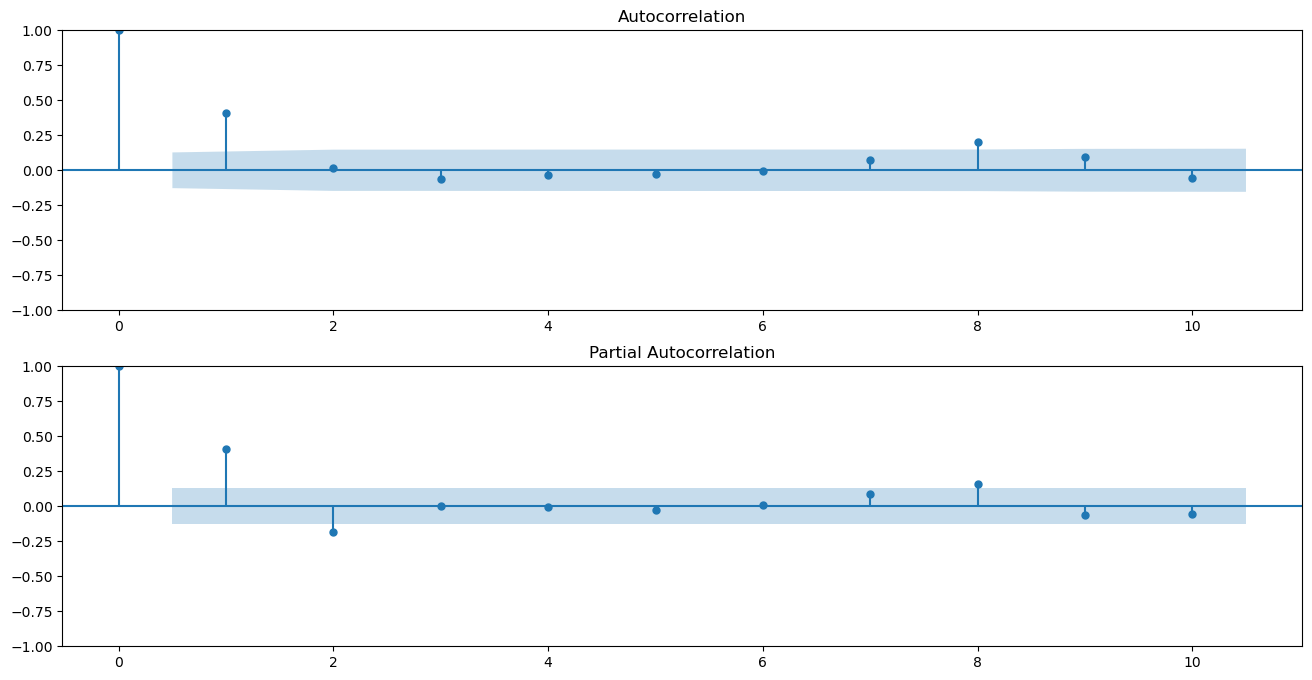

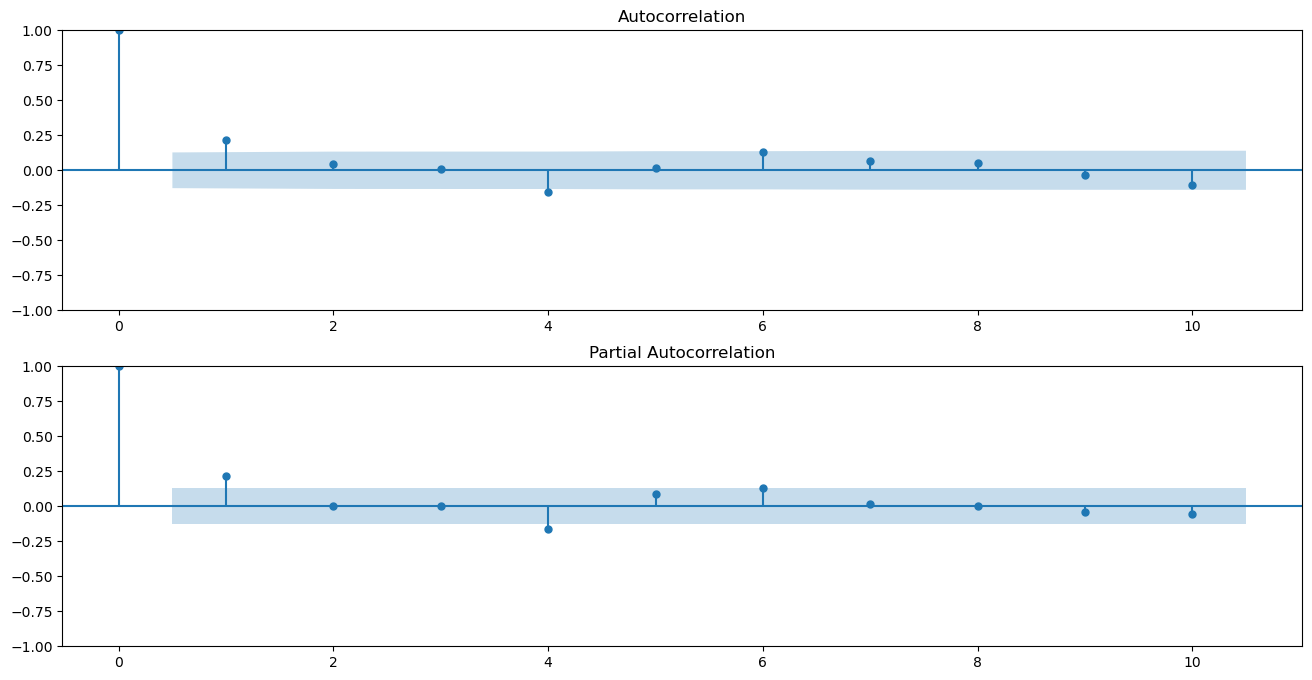

In [279]:
def Show_acf(data):
  fig, ax = plt.subplots(2, figsize=(16,8))
  n_lag = 10
  significance_level=0.05
  plot_acf(data.diff(1).dropna(), ax = ax[0], lags=n_lag, alpha=significance_level)
  plot_pacf(data.diff(1).dropna(), ax = ax[1], lags = n_lag, alpha= significance_level)
Show_acf(train_set.Y_train_CVT)
Show_acf(train_set.Y_train_HBC)
Show_acf(train_set.Y_train_HT1)
Show_acf(train_set.Y_train_ACC)
Show_acf(train_set.Y_train_VCG)

Sau khi kiểm định chuỗi dữ lieuj và khắc phục bằng cách lấy sai phân, chuỗi đã dừng tại sai phân bậc 1. Vì vậy I(d) =1. Sử dụng đồ thị ACF, PACF xác định các tham số p,q của mô hình. Ngoài ra, t cũng có thể sử dụng phương pháp thử và tăng dần p,q và lựa chọn mô hình có AIC nhỏ nhất

In [351]:
# Thử ARIMA với CVT
arima_model_CVT = ARIMA(train_set.Y_train_VCG, order=(1,1,0))
arima_fit=arima_model_CVT.fit()
arima_fit.summary()

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Y_train_VCG   No. Observations:                  237
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1999.345
Date:                Tue, 21 May 2024   AIC                           4002.691
Time:                        08:22:27   BIC                           4009.619
Sample:                    01-06-2019   HQIC                          4005.483
                         - 07-16-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1822      0.041      4.411      0.000       0.101       0.263
sigma2      1.334e+06   6.99e+04     19.078      0.000     1.2e+06    1.47e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               263.26
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):              12.82   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

9. Sử dụng auto ARIMA để tìm ra best model

In [280]:
model_autoARIMA_CVT = pm.auto_arima(train_set.Y_train_CVT, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4,
                      m=0,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA_CVT.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4158.270, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4150.902, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4147.808, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4156.801, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4147.085, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4148.210, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4148.526, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4146.533, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4148.560, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4148.363, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4144.886, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4146.044, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4146.865, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4146.875, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [281]:
model_autoARIMA_HBC = pm.auto_arima(train_set.Y_train_HBC, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4,
                      m=0,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA_HBC.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3908.208, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3898.049, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3896.931, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3906.266, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3898.592, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3898.689, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3900.502, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3895.006, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3896.652, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3896.766, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3896.124, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3898.574, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.910 seconds
                               SARIMAX Results                                
Dep. Vari

In [282]:
model_autoARIMA_HT1 = pm.auto_arima(train_set.Y_train_HT1, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4,
                      m=0,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA_HT1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3806.806, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3799.752, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3800.055, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3804.904, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3801.692, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3801.362, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3803.014, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3797.783, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3799.721, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3799.376, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3798.087, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3801.018, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.988 seconds
                               SARIMAX Results                                
Dep. Vari

In [283]:
model_autoARIMA_ACC = pm.auto_arima(train_set.Y_train_ACC, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4,
                      m=0,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA_ACC.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3819.832, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3786.708, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3783.284, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3817.834, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3784.700, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3784.555, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3785.831, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3781.277, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3782.691, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3782.559, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3784.694, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3783.834, Time=0.11 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.040 seconds
                               SARIMAX Results                                
Dep. Vari

In [284]:
model_autoARIMA_VCG = pm.auto_arima(train_set.Y_train_VCG, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4,
                      m=0,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA_VCG.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4012.356, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4004.631, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4004.842, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4010.523, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4006.636, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4006.647, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4007.820, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4002.691, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4004.696, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4004.709, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4002.922, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4006.589, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.054 seconds
                               SARIMAX Results                                
Dep. Vari

10. Fit mô hình

In [285]:
model1 = ARIMA(train_set.Y_train_CVT, order=(0,1,2))
model_fit_CVT = model1.fit()
model2 = ARIMA(train_set.Y_train_HBC, order=(0,1,1))
model_fit_HBC = model2.fit()
model3 = ARIMA(train_set.Y_train_HT1, order=(1,1,0))
model_fit_HT1 = model3.fit()
model4 = ARIMA(train_set.Y_train_ACC, order=(0,1,1))
model_fit_ACC = model4.fit()
model5 = ARIMA(train_set.Y_train_VCG, order=(1,1,0))
model_fit_VCG = model5.fit()

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will b

Text(0.5, 1.0, 'Autocorrelation Plot of Residual')

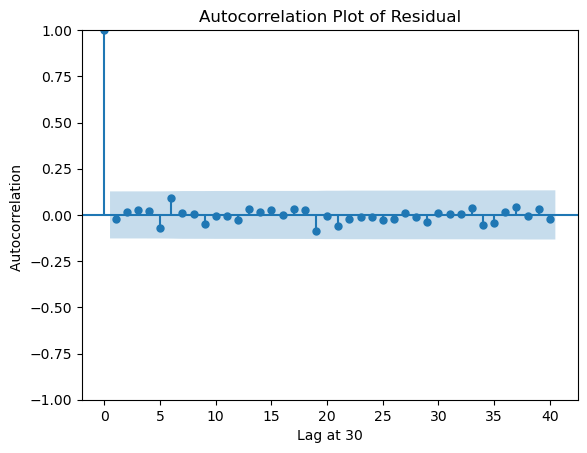

In [286]:
# Biểu đồ ACF của phần dư
plot_acf(model_fit_CVT.resid, lags=40, alpha = 0.05)
plt.ylabel("Autocorrelation ")
plt.xlabel('Lag at 30')
plt.title('Autocorrelation Plot of Residual')

Text(0.5, 1.0, 'Autocorrelation Plot of Residual')

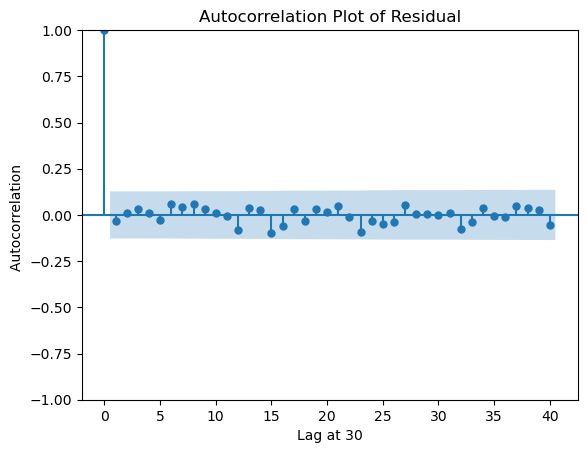

In [287]:
plot_acf(model_fit_HBC.resid, lags=40, alpha = 0.05)
plt.ylabel("Autocorrelation ")
plt.xlabel('Lag at 30')
plt.title('Autocorrelation Plot of Residual')

Text(0.5, 1.0, 'Autocorrelation Plot of Residual')

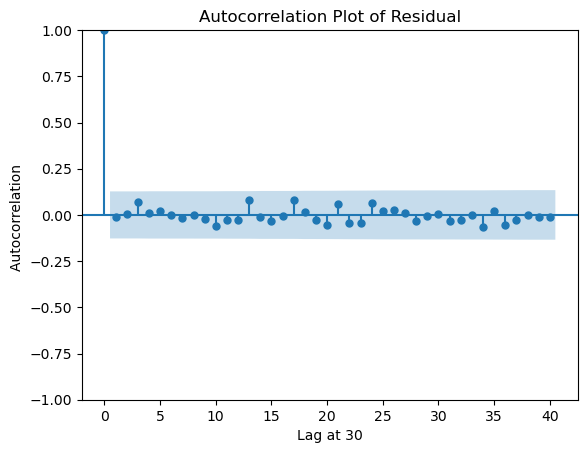

In [288]:
plot_acf(model_fit_HT1.resid, lags=40, alpha = 0.05)
plt.ylabel("Autocorrelation ")
plt.xlabel('Lag at 30')
plt.title('Autocorrelation Plot of Residual')

Text(0.5, 1.0, 'Autocorrelation Plot of Residual')

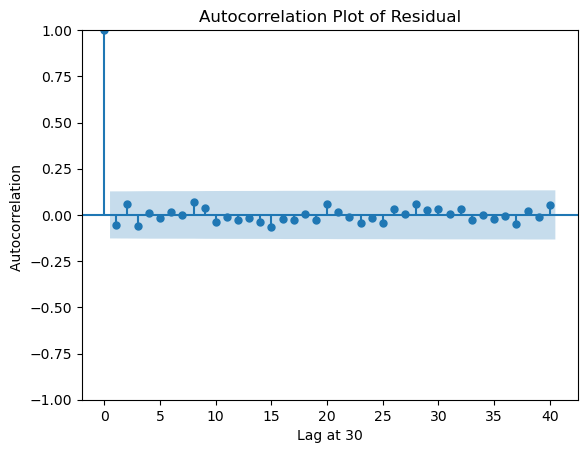

In [289]:
plot_acf(model_fit_ACC.resid, lags=40, alpha = 0.05)
plt.ylabel("Autocorrelation ")
plt.xlabel('Lag at 30')
plt.title('Autocorrelation Plot of Residual')

Text(0.5, 1.0, 'Autocorrelation Plot of Residual')

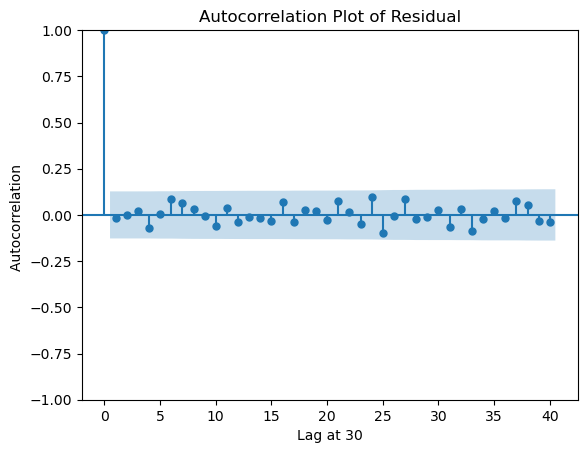

In [290]:
plot_acf(model_fit_VCG.resid, lags=40, alpha = 0.05)
plt.ylabel("Autocorrelation ")
plt.xlabel('Lag at 30')
plt.title('Autocorrelation Plot of Residual')

11. Dự báo trong mẫu

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

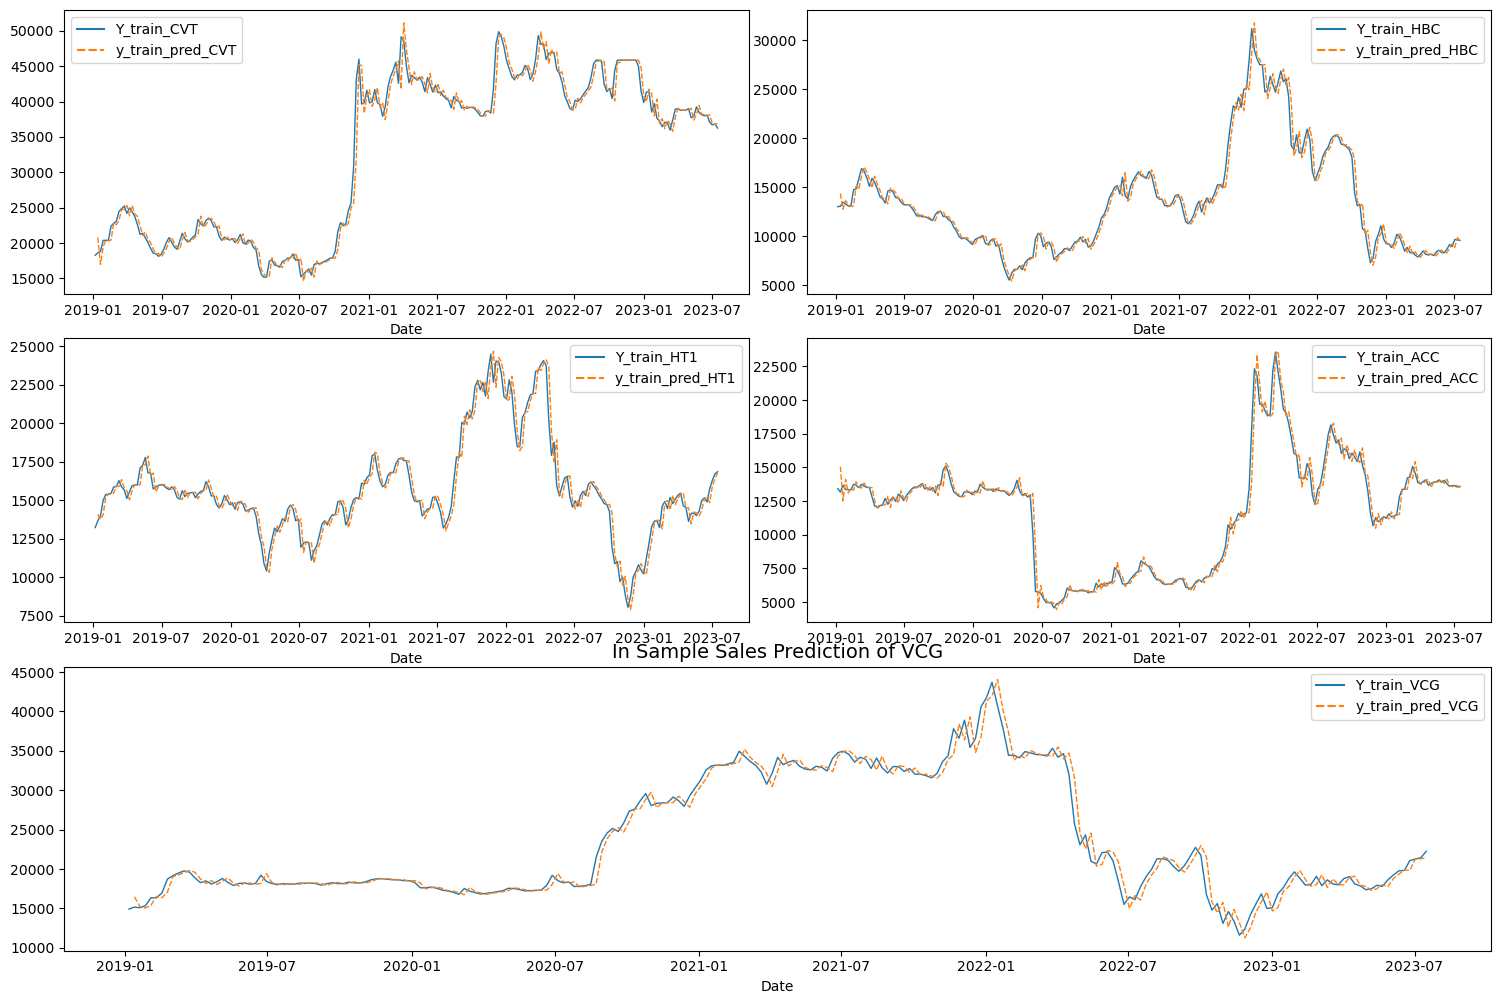

In [291]:
fig = plt.figure(figsize=(15,10))
axes1 = plt.subplot2grid((3,2), (0,0))
axes2 = plt.subplot2grid((3,2), (0,1))
axes3 = plt.subplot2grid((3,2), (1,0))
axes4 = plt.subplot2grid((3,2), (1,1))
axes5 = plt.subplot2grid((3,2), (2,0), colspan = 2)
fig.tight_layout()
# Show kết quả dự báo trong mẫu
def Pred_in_sample(auto_model, x, y):
    pred = auto_model.predict_in_sample(dynamic=False)
    train_set[f'y_train_pred_{x}'] = pred[1:]
    plt.title(f"In Sample Sales Prediction of {x}", fontsize=14)
    sns.lineplot(data=train_set[[f'Y_train_{x}', f'y_train_pred_{x}']], linewidth=1.0, ax = y)
Pred_in_sample(model_autoARIMA_CVT,"CVT", axes1)
Pred_in_sample(model_autoARIMA_HBC, "HBC", axes2)
Pred_in_sample(model_autoARIMA_HT1, "HT1", axes3)
Pred_in_sample(model_autoARIMA_ACC, "ACC" , axes4)
Pred_in_sample(model_autoARIMA_VCG, "VCG", axes5)





In [292]:
train_set

,Y_train_CVT,Y_train_HBC,Y_train_HT1,Y_train_ACC,Y_train_VCG,y_train_pred_CVT,y_train_pred_HBC,y_train_pred_HT1,y_train_pred_ACC,y_train_pred_VCG
Date,,,,,,,,,,
2019-01-06,18266.666016,13038.100586,13233.333008,13415.899414,14896.066406,NaN,NaN,NaN,NaN,NaN
2019-01-13,18610.000000,13068.020508,13680.000000,13163.919922,15168.900391,20793.626695,14379.544145,14106.156803,15054.159424,16469.177113
2019-01-20,18840.000000,13492.220703,14010.000000,13667.820312,15076.458984,16974.082829,12773.575710,13760.154271,12507.250619,15218.602250
2019-01-27,20370.000000,13312.720703,15000.000000,13368.675781,15340.500000,19453.497289,13658.089681,14069.218411,14105.236499,15059.619038
2019-02-03,20390.000000,13100.660156,15380.000000,13334.020508,16343.861328,20399.819747,13232.890680,15177.655233,13087.946607,15388.600054
...,...,...,...,...,...,...,...,...,...,...
2023-06-18,38087.500000,9164.000000,14900.000000,13590.000000,19813.640625,37930.423831,8769.180423,15202.300951,13665.228621,19861.375610
2023-06-25,37100.000000,8954.000000,15750.000000,13650.000000,21070.000000,38145.073688,9255.267734,14851.548573,13561.273434,19822.745511
2023-07-02,36687.500000,9688.000000,16290.000000,13640.000000,21260.000000,36850.562704,8884.358004,15902.532271,13683.880850,21298.869570


12. Đánh giá các hệ số  xác định mô hình

In [293]:
def Evaluate(pred,data,x):
    print(f"Evaluate for {x}")
    MAPE = np.mean(np.abs((pred-data)/data)* 100)
    print("MAPE = ", MAPE)
    MAE = mean_absolute_error(pred,data)
    print("MAE = ", MAE)
    MSE = mean_squared_error(pred,data)
    RMSE = math.sqrt(MSE)
    print("RMSE = ", RMSE)
    print("\n")
Evaluate(train_set.y_train_pred_CVT[1:], train_set.Y_train_CVT[1:],"CVT")
Evaluate(train_set.y_train_pred_HBC[1:], train_set.Y_train_HBC[1:],"HBC")
Evaluate(train_set.y_train_pred_HT1[1:], train_set.Y_train_HT1[1:],"HT1")
Evaluate(train_set.y_train_pred_ACC[1:], train_set.Y_train_ACC[1:],"ACC")
Evaluate(train_set.y_train_pred_VCG[1:], train_set.Y_train_VCG[1:],"VCG")

Evaluate for CVT
MAPE =  3.044950896997643
MAE =  966.1751855519328
RMSE =  1556.0922657588078


Evaluate for HBC
MAPE =  4.68514133389867
MAE =  631.3338682405985
RMSE =  920.3479370799004


Evaluate for HT1
MAPE =  3.473833647240767
MAE =  532.9473586273041
RMSE =  748.9755651010056


Evaluate for ACC
MAPE =  3.945872254347156
MAE =  452.61764780018046
RMSE =  723.8688432608349


Evaluate for VCG
MAPE =  3.339826669189524
MAE =  757.5662078220477
RMSE =  1156.1728476892924




13. Dự báo ngoài mẫu

In [294]:
# dự báo ngoài mẫu
def Pred_out_sample(model_fit,k):
    forecast = model_fit.get_forecast(k)
    yhat = forecast.predicted_mean
    yhat_conf_int = forecast.conf_int(alpha=0.05)
    return yhat, yhat_conf_int

In [295]:
yhat_CVT, yhat_conf_int_CVT =Pred_out_sample(model_fit_CVT, 27)
yhat_HBC, yhat_conf_int_HBC =Pred_out_sample(model_fit_HBC, 27)
yhat_HT1, yhat_conf_int_HT1 =Pred_out_sample(model_fit_HT1, 27)
yhat_ACC, yhat_conf_int_ACC =Pred_out_sample(model_fit_ACC, 27)
yhat_VCG, yhat_conf_int_VCG =Pred_out_sample(model_fit_VCG, 27)

In [296]:
yhat_conf_int_ACC

,lower Y_train_ACC,upper Y_train_ACC
2023-07-23,12228.786547,15013.675476
2023-07-30,11246.091161,15996.370861
2023-08-06,10564.488132,16677.973890
2023-08-13,10009.297354,17233.164669
2023-08-20,9528.743691,17713.718332
2023-08-27,9098.970494,18143.491529
2023-09-03,8706.637650,18535.824373
2023-09-10,8343.389063,18899.072959
2023-09-17,8003.579959,19238.882064
2023-09-24,7683.184946,19559.277076


Y_train_CVT          mean      mean_se  mean_ci_lower  mean_ci_upper
2023-07-23   36082.036378  1562.836288   33018.933541   39145.139216
2023-07-30   36143.639750  2470.696310   31301.163966   40986.115535
2023-08-06   36143.639750  3036.712171   30191.793264   42095.486236
2023-08-13   36143.639750  3512.677235   29258.918880   43028.360620
2023-08-20   36143.639750  3931.435095   28438.168556   43849.110944
2023-08-27   36143.639750  4309.694010   27696.794707   44590.484794
2023-09-03   36143.639750  4657.332177   27015.436419   45271.843081
2023-09-10   36143.639750  4980.765359   26381.519032   45905.760469
2023-09-17   36143.639750  5284.439810   25786.328044   46500.951457
2023-09-24   36143.639750  5571.587266   25223.529373   47063.750128
2023-10-01   36143.639750  5844.644147   24688.347719   47598.931781
2023-10-08   36143.639750  6105.501270   24177.077153   48110.202347
2023-10-15   36143.639750  6355.660966   23686.773160   48600.506341
2023-10-22   36143.639750  6596.34

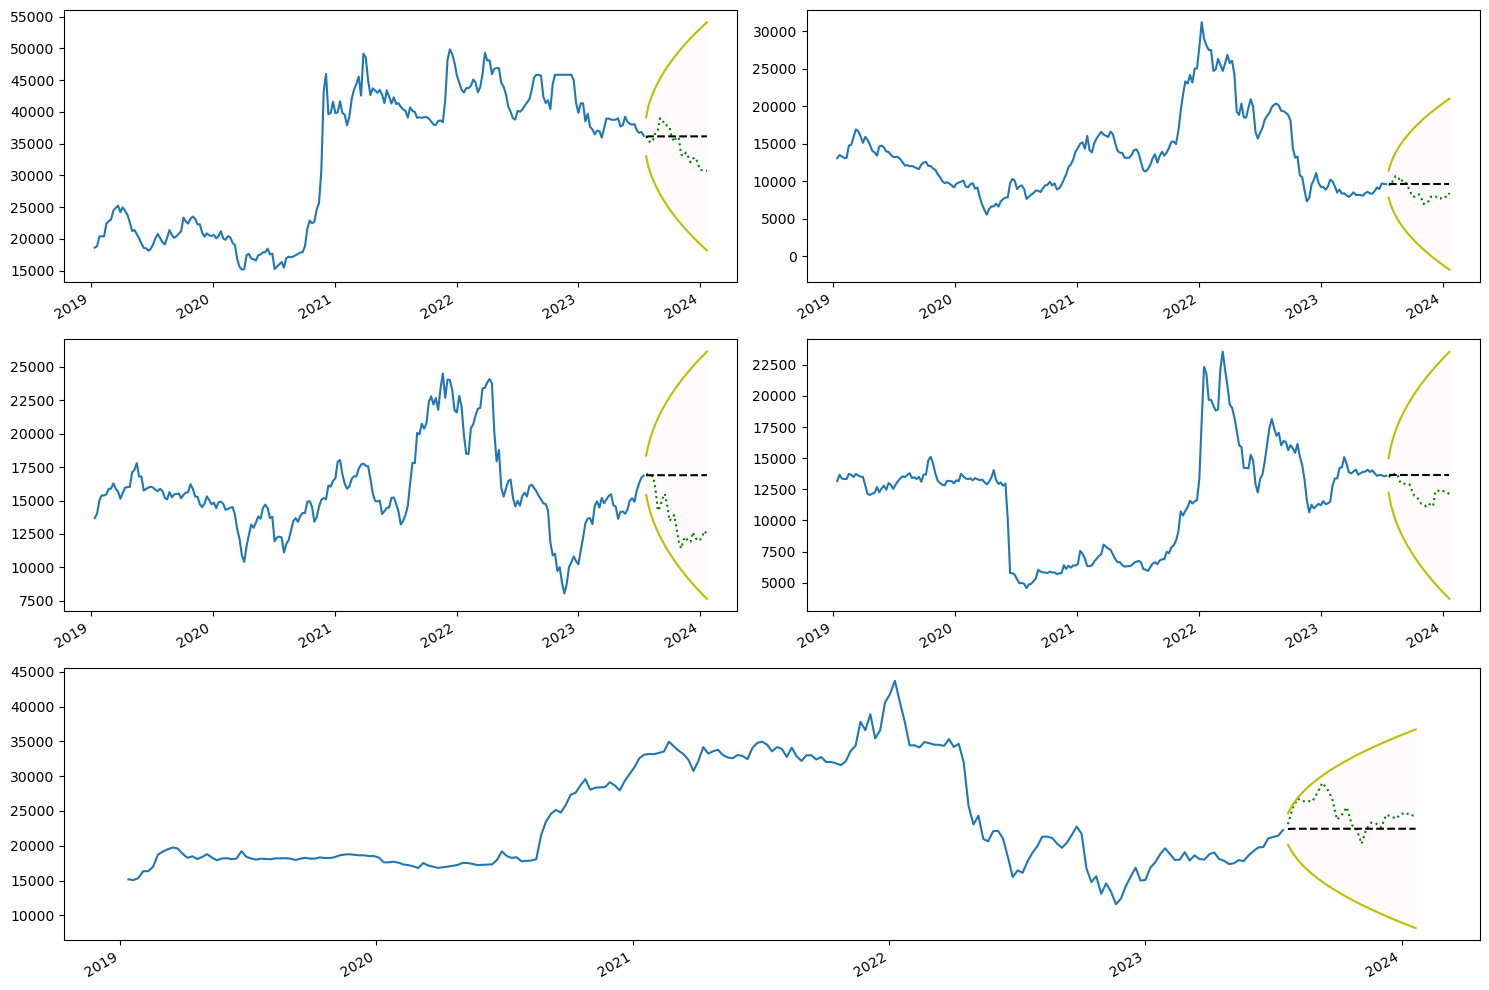

In [297]:
# So sánh kết quả dự báo và thực tế
fig = plt.figure(figsize=(15,10))
axes1 = plt.subplot2grid((3,2), (0,0))
axes2 = plt.subplot2grid((3,2), (0,1))
axes3 = plt.subplot2grid((3,2), (1,0))
axes4 = plt.subplot2grid((3,2), (1,1))
axes5 = plt.subplot2grid((3,2), (2,0), colspan = 2)
fig.tight_layout()
def Show2(model_fit,data_train, data_set, conf1, conf2, ax, k):
    ax.plot(data_train[1:], label='training')
    ax.plot(data_set, 'g:', label='actual')
    ax.plot(conf1, color= 'y',label='Confidence Interval Upper bound ')
    ax.plot(conf2, color= 'y',label='Confidence Interval Lower bound ')
# In ra kết quả dự báo
    fcast = model_fit.get_forecast(k).summary_frame()
    print(fcast)
    fcast["mean"].plot(ax=ax, style='k--')
    ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='pink', alpha=0.05)
    fig.tight_layout()
Show2(model_fit_CVT,train_set.Y_train_CVT, test_set.Y_test_CVT, yhat_conf_int_CVT["lower Y_train_CVT"], yhat_conf_int_CVT["upper Y_train_CVT"],axes1, 27)
Show2(model_fit_HBC,train_set.Y_train_HBC, test_set.Y_test_HBC, yhat_conf_int_HBC["lower Y_train_HBC"], yhat_conf_int_HBC["upper Y_train_HBC"],axes2, 27)
Show2(model_fit_HT1,train_set.Y_train_HT1, test_set.Y_test_HT1, yhat_conf_int_HT1["lower Y_train_HT1"], yhat_conf_int_HT1["upper Y_train_HT1"],axes3, 27)
Show2(model_fit_ACC,train_set.Y_train_ACC, test_set.Y_test_ACC, yhat_conf_int_ACC["lower Y_train_ACC"], yhat_conf_int_ACC["upper Y_train_ACC"],axes4, 27)
Show2(model_fit_VCG,train_set.Y_train_VCG, test_set.Y_test_VCG, yhat_conf_int_VCG["lower Y_train_VCG"], yhat_conf_int_VCG["upper Y_train_VCG"],axes5, 27)


14. Hồi quy với SARIMA. (Xét đến yêu tố mùa vụ, ss với ARIM)

In [298]:
model_autoSARIMA_CVT = pm.auto_arima(train_set.Y_train_CVT, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4,
                      m=12,
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoSARIMA_CVT.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=4160.105, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4158.270, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4152.705, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4149.624, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4156.801, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4147.808, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4149.627, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4151.620, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=4147.085, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=4148.956, Time=0.19 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=4148.952, Time=0.22 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=4150.927, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4150.902, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=4148.210, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0

In [299]:
model_autoSARIMA_HBC = pm.auto_arima(train_set.Y_train_HBC, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4,
                      m=12,
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoSARIMA_HBC.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3906.878, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3908.208, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3896.492, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3895.353, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3906.266, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3896.931, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3896.972, Time=0.22 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=3896.961, Time=0.23 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3895.670, Time=0.10 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=3898.952, Time=0.41 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3897.233, Time=0.18 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=3897.242, Time=0.19 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3896.125, Time=0.13 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=3899.119, Time=0.57 sec
 ARIMA(0,1,1)(0,0,1

In [300]:
model_autoSARIMA_HT1 = pm.auto_arima(train_set.Y_train_HT1, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4,
                      m=12,
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoSARIMA_HT1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3808.760, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3806.806, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3801.591, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3801.862, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3804.904, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3799.752, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3801.624, Time=0.12 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3798.836, Time=0.51 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3797.367, Time=0.90 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3799.018, Time=0.23 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3796.674, Time=0.89 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3799.921, Time=0.30 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3803.944, Time=1.06 sec
 ARIMA(2,1,0)(1,0,2)[12]

In [302]:
model_autoSARIMA_ACC = pm.auto_arima(train_set.Y_train_ACC, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4,
                      m=12,
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoSARIMA_ACC.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3820.638, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3819.832, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3788.157, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3784.321, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3817.834, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3783.284, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3784.323, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3786.321, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3784.700, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=3784.555, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3786.708, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=3785.831, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=3781.277, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=3782.318, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1

In [303]:
model_autoSARIMA_VCG = pm.auto_arima(train_set.Y_train_VCG, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4,
                      m=12,
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoSARIMA_VCG.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=4013.971, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4012.356, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4006.059, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4006.293, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4010.523, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4004.631, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4006.165, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4004.020, Time=0.27 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4005.030, Time=0.43 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=4005.104, Time=0.49 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=4004.915, Time=0.19 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4004.310, Time=0.27 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=4006.560, Time=0.62 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4014.333, Time=0.19 sec
 ARIMA(2,1,0)(1,0,1

In [304]:
model1s = ARIMA(train_set.Y_train_HBC, order=(0,1,1), seasonal_order=(0,0,1,12))
sarima_fit_HBC = model1s.fit()
model2s = ARIMA(train_set.Y_train_HT1, order=(1,1,0), seasonal_order=(1,0,2,12))
sarima_fit_HT1 = model2s.fit()
model3s = ARIMA(train_set.Y_train_VCG, order=(1,1,0), seasonal_order=(1,0,1,12))
sarima_fit_VCG = model3s.fit()


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will b

In [353]:
# dự báo trong mẫu
pred1 = model_autoSARIMA_HBC.predict_in_sample(dynamic=False)
pred2 = model_autoSARIMA_HT1.predict_in_sample(dynamic=False)
pred3 = model_autoSARIMA_VCG.predict_in_sample(dynamic=False)
Evaluate(pred1[1:], train_set.Y_train_HBC[1:],"HBC")
Evaluate(pred2[1:], train_set.Y_train_HT1[1:],"HT1")
Evaluate(pred3[1:], train_set.Y_train_VCG[1:],"VCG")


Evaluate for HBC
MAPE =  4.683666928717523
MAE =  625.134599796028
RMSE =  913.2485380921303


Evaluate for HT1
MAPE =  3.5294849098503884
MAE =  542.9163321631875
RMSE =  733.8221555656376


Evaluate for VCG
MAPE =  3.306468770976093
MAE =  750.0436060317004
RMSE =  1143.880471189237




In [258]:
data.describe()

,Price_CVT,Price_HBC,Price_HT1,Price_ACC,Price_VCG
count,264.000000,264.000000,264.000000,264.000000,264.000000
mean,32962.882812,13060.211914,15504.176758,11817.578125,23636.523438
std,10683.874023,5259.863770,3095.168213,3923.613037,7172.985352
min,15150.000000,5541.700195,8056.000000,4568.739746,11590.919922
25%,20845.000000,9131.939941,13833.699707,7730.024902,18071.379883
50%,37620.000000,12020.090332,15140.000000,12932.560059,20377.269531
75%,41508.758789,15201.610352,16289.055176,13692.534424,31365.674805
max,49860.000000,31203.250000,24488.140625,23559.500000,43708.226562


In [305]:
# dự báo ngoài mẫu
yhats_HBC, yhats_conf_int_HBC=Pred_out_sample(sarima_fit_HBC,27)
yhats_HT1, yhats_conf_int_HT1=Pred_out_sample(sarima_fit_HT1,27)
yhats_VCG, yhats_conf_int_VCG=Pred_out_sample(sarima_fit_VCG,27)

In [306]:
yhats_VCG

2023-07-23    22494.328557
2023-07-30    22531.379488
2023-08-06    22395.882643
2023-08-13    22511.251242
2023-08-20    22371.623714
2023-08-27    22377.490985
2023-09-03    22369.266728
2023-09-10    22083.325401
2023-09-17    21853.073573
2023-09-24    21917.896392
2023-10-01    21585.418861
2023-10-08    21596.142989
2023-10-15    21543.918501
2023-10-22    21543.126720
2023-10-29    21667.896545
2023-11-05    21568.577678
2023-11-12    21690.698970
2023-11-19    21685.637182
2023-11-26    21692.825815
2023-12-03    21942.344715
2023-12-10    22143.266203
2023-12-17    22086.701009
2023-12-24    22376.825583
2023-12-31    22367.467564
2024-01-07    22413.039384
2024-01-14    22413.730304
2024-01-21    22304.854406
Freq: W-SUN, Name: predicted_mean, dtype: float64

Y_train_HBC         mean      mean_se  mean_ci_lower  mean_ci_upper
2023-07-23   9612.181122   921.676317    7805.728735   11418.633510
2023-07-30   9639.646442  1460.319205    6777.473393   12501.819490
2023-08-06   9606.100399  1848.128007    5983.836067   13228.364731
2023-08-13   9578.726679  2167.630521    5330.248926   13827.204433
2023-08-20   9611.311148  2445.744677    4817.739666   14404.882630
2023-08-27   9613.333421  2695.312964    4330.617085   14896.049757
2023-09-03   9576.666231  2923.654720    3846.408277   15306.924185
2023-09-10   9523.871564  3135.410957    3378.579012   15669.164116
2023-09-17   9545.208795  3333.743664    3011.191281   16079.226310
2023-09-24   9453.658608  3520.922005    2552.778287   16354.538929
2023-10-01   9464.298240  3698.639846    2215.097350   16713.499130
2023-10-08   9467.491082  3868.201347    1885.955758   17049.026406
2023-10-15   9466.478484  4001.168728    1624.331880   17308.625087
2023-10-22   9466.478484  4123.702286    1384.17

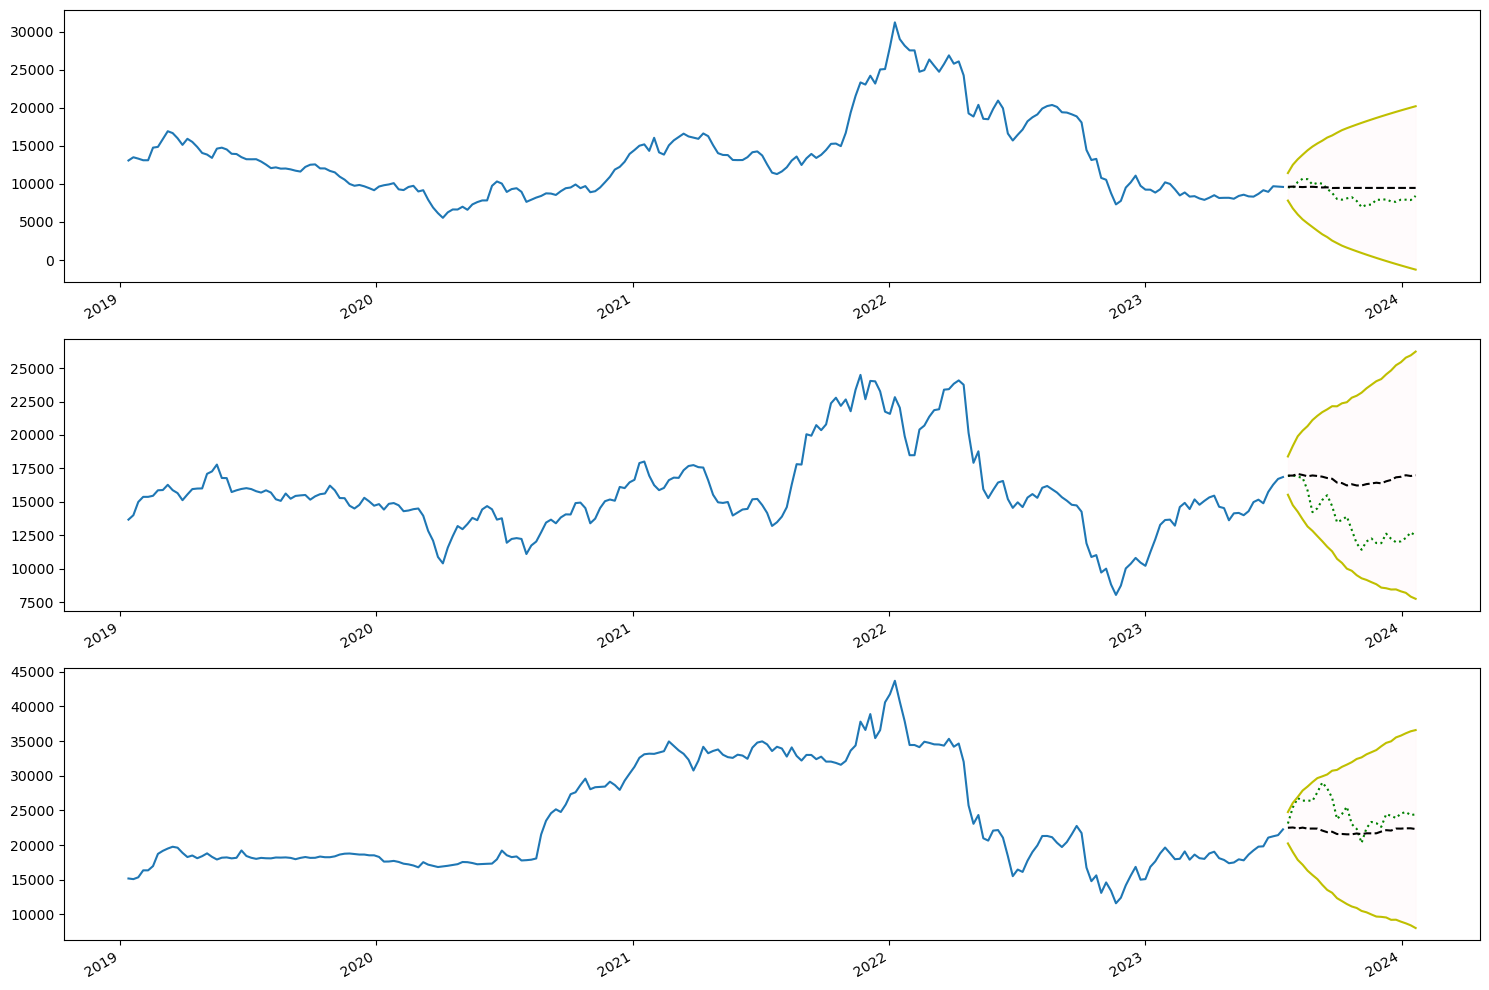

In [309]:
# So sánh kết quả dự báo và thực tế
fig = plt.figure(figsize=(15,10))
axes1 = plt.subplot2grid((3,1), (0,0))
axes2 = plt.subplot2grid((3,1), (1,0))
axes3 = plt.subplot2grid((3,1), (2,0))
fig.tight_layout()
Show2(sarima_fit_HBC, train_set.Y_train_HBC, test_set.Y_test_HBC, yhats_conf_int_HBC["lower Y_train_HBC"], yhats_conf_int_HBC["upper Y_train_HBC"],axes1,27)
Show2(sarima_fit_HT1, train_set.Y_train_HT1, test_set.Y_test_HT1, yhats_conf_int_HT1["lower Y_train_HT1"], yhats_conf_int_HT1["upper Y_train_HT1"],axes2,27)
Show2(sarima_fit_VCG, train_set.Y_train_VCG, test_set.Y_test_VCG, yhats_conf_int_VCG["lower Y_train_VCG"], yhats_conf_int_VCG["upper Y_train_VCG"],axes3,27)